In [ ]:
!apt install -y python-opengl ffmpeg > /dev/null 2>&1
%pip install pyvirtualdisplay highway-env stable_baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 59.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.0/170.0 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 KB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pprint
import gym
import highway_env

env = gym.make('highway-v0')
env.observation_space.shape
env.config

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'normalize_reward': True,
 'offroad_terminal': False}

In [ ]:
obs = env.reset()
print(obs)

NameError: ignored

In [ ]:
ACTIONS_ALL = {
    0: 'LANE_LEFT',
    1: 'IDLE',
    2: 'LANE_RIGHT',
    3: 'FASTER',
    4: 'SLOWER'
}

In [ ]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import gym
from collections import deque

## Part 2

In [ ]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import gym
from collections import deque

# define policy network
class policy_net(nn.Module):
    def __init__(self, nS, nH, nA): # nS: state space size, nH: n. of neurons in hidden layer, nA: size action space
        super(policy_net, self).__init__()
        self.h = nn.Linear(nS, nH)
        self.out = nn.Linear(nH, nA)

    # define forward pass with one hidden layer with ReLU activation and sofmax after output layer
    def forward(self, x):
        #print("x", x.shape)
        x = F.relu(self.h(x))
        #print(x.shape)
        x = F.softmax(self.out(x), dim=1)
        #print(x.shape)
        return x
def n_run(n):
  n_rewards = []
  for i in range(n):
      # create environment
      #env = gym.make("CartPole-v1")
      env = gym.make("merge-v0")
      # instantiate the policy
      policy = policy_net(env.observation_space.shape[0]*5, 20, env.action_space.n).to(device)
      # create an optimizer
      optimizer = torch.optim.Adam(policy.parameters())
      # initialize gamma and stats
      gamma=0.99
      n_episode = 1
      returns = []
      ave_returns = []
      render_rate = 100 # render every render_rate episodes
      episode_num = 0
      while True:
          rewards = []
          actions = []
          states  = []
          # reset environment
          state, info = env.reset()
          while True:
              # render episode every render_rate epsiodes
              #if n_episode%render_rate==0:
                  #env.render()

              # calculate probabilities of taking each action
              probs = policy(torch.tensor(state.flatten()).unsqueeze(0).float().to(device))
              # sample an action from that set of probs
              sampler = Categorical(probs)
              action = sampler.sample()

              # use that action in the environment
              new_state, reward, done,_, info = env.step(action.item())
              # store state, action and reward
              states.append(state)
              actions.append(action)
              rewards.append(reward)
              state = new_state
              if done:
                  break
          episode_num += 1
          if episode_num > 500:
            break
          # preprocess rewards
          rewards = np.array(rewards)
          # calculate rewards to go for less variance
          R = torch.tensor([np.sum(rewards[i:]*(gamma**np.array(range(i, len(rewards))))) for i in range(len(rewards))]).to(device)
          # or uncomment following line for normal rewards
          #R = torch.sum(torch.tensor(rewards))

          # preprocess states and actions
          states = torch.tensor(states).float()
          actions = torch.tensor(actions)

          # calculate gradient
          probs = policy(states.flatten(1).to(device)).to(device)
          sampler = Categorical(probs)
          log_probs = -sampler.log_prob(actions.to(device))   # "-" because it was built to work with gradient descent, but we are using gradient ascent
          pseudo_loss = torch.sum(log_probs * R) # loss that when differentiated with autograd gives the gradient of J(θ)
          # update policy weights
          optimizer.zero_grad()
          pseudo_loss.backward()
          optimizer.step()

          # calculate average return and print it out
          returns.append(np.sum(rewards))
          ave_returns.append(np.mean(returns))
          print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
          n_episode += 1

      # close environment
      env.close()
      n_rewards.append(ave_returns)
  return n_rewards, policy

In [ ]:
n_rewards, model = n_run(5)

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


Episode:      1	Avg. Return:  11.86
Episode:      2	Avg. Return:  11.42
Episode:      3	Avg. Return:  11.12
Episode:      4	Avg. Return:  11.70
Episode:      5	Avg. Return:  11.61
Episode:      6	Avg. Return:  11.63
Episode:      7	Avg. Return:  11.83
Episode:      8	Avg. Return:  11.69
Episode:      9	Avg. Return:  11.37
Episode:     10	Avg. Return:  11.56
Episode:     11	Avg. Return:  11.41
Episode:     12	Avg. Return:  11.37
Episode:     13	Avg. Return:  11.37
Episode:     14	Avg. Return:  11.26
Episode:     15	Avg. Return:  11.17
Episode:     16	Avg. Return:  11.30
Episode:     17	Avg. Return:  11.40
Episode:     18	Avg. Return:  11.08
Episode:     19	Avg. Return:  11.09
Episode:     20	Avg. Return:  11.05
Episode:     21	Avg. Return:  11.02
Episode:     22	Avg. Return:  11.04
Episode:     23	Avg. Return:  10.96
Episode:     24	Avg. Return:  11.10
Episode:     25	Avg. Return:  11.20
Episode:     26	Avg. Return:  11.21
Episode:     27	Avg. Return:  11.18
Episode:     28	Avg. Return:

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/RL/HW5/model_weights.pth')

In [ ]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/RL/HW5/model_weights.pth'))

Text(0.5, 0, 'episodes')

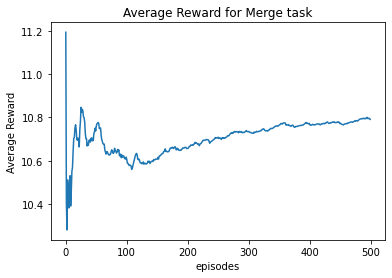

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.mean(n_rewards, axis = 0))
plt.title("Average Reward for Merge task")
plt.ylabel("Average Reward")
plt.xlabel("episodes")

## Part 3

### Random Initialization

In [ ]:
def n_run_3(n):
  n_rewards = []
  for i in range(n):
      # create environment
      #env = gym.make("CartPole-v1")
      env = gym.make("highway-fast-v0")
      # instantiate the policy
      policy = policy_net(env.observation_space.shape[0]*5, 20, env.action_space.n).to(device)     # create an optimizer
      optimizer = torch.optim.Adam(policy.parameters())
      # initialize gamma and stats
      gamma=0.99
      n_episode = 1
      returns = []
      ave_returns = []
      render_rate = 100 # render every render_rate episodes
      episode_num = 0
      while True:
          rewards = []
          actions = []
          states  = []
          # reset environment
          state, info = env.reset()
          while True:
              # render episode every render_rate epsiodes
              #if n_episode%render_rate==0:
                  #env.render()

              # calculate probabilities of taking each action
              probs = policy(torch.tensor(state.flatten()).unsqueeze(0).float().to(device))
              # sample an action from that set of probs
              sampler = Categorical(probs)
              action = sampler.sample()

              # use that action in the environment
              new_state, reward, done,_, info = env.step(action.item())
              # store state, action and reward
              states.append(state)
              actions.append(action)
              rewards.append(reward)
              state = new_state
              if done:
                  break
          episode_num += 1
          if episode_num > 500:
            break
          # preprocess rewards
          rewards = np.array(rewards)
          # calculate rewards to go for less variance
          R = torch.tensor([np.sum(rewards[i:]*(gamma**np.array(range(i, len(rewards))))) for i in range(len(rewards))]).to(device)
          # or uncomment following line for normal rewards
          #R = torch.sum(torch.tensor(rewards))

          # preprocess states and actions
          states = torch.tensor(states).float().to(device)
          actions = torch.tensor(actions).to(device)

          # calculate gradient
          probs = policy(states.flatten(1).to(device)).to(device)
          sampler = Categorical(probs)
          log_probs = -sampler.log_prob(actions.to(device))   # "-" because it was built to work with gradient descent, but we are using gradient ascent
          pseudo_loss = torch.sum(log_probs * R) # loss that when differentiated with autograd gives the gradient of J(θ)
          # update policy weights
          optimizer.zero_grad()
          pseudo_loss.backward()
          optimizer.step()

          # calculate average return and print it out
          returns.append(np.sum(rewards))
          ave_returns.append(np.mean(returns))
          print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
          n_episode += 1

      # close environment
      env.close()
      n_rewards.append(ave_returns)
  return n_rewards, policy

In [ ]:
n_rewards3, model3 = n_run_3(5)

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


Episode:      1	Avg. Return:  11.72
Episode:      2	Avg. Return:   7.51
Episode:      3	Avg. Return:  10.67
Episode:      4	Avg. Return:  11.71
Episode:      5	Avg. Return:  10.63
Episode:      6	Avg. Return:  11.16
Episode:      7	Avg. Return:  10.46
Episode:      8	Avg. Return:  10.60
Episode:      9	Avg. Return:   9.56
Episode:     10	Avg. Return:   8.91
Episode:     11	Avg. Return:   9.07
Episode:     12	Avg. Return:   9.33
Episode:     13	Avg. Return:   8.75
Episode:     14	Avg. Return:   9.85
Episode:     15	Avg. Return:   9.36
Episode:     16	Avg. Return:   8.89
Episode:     17	Avg. Return:   8.67
Episode:     18	Avg. Return:   8.69
Episode:     19	Avg. Return:   8.57
Episode:     20	Avg. Return:   8.24
Episode:     21	Avg. Return:   8.13
Episode:     22	Avg. Return:   7.89
Episode:     23	Avg. Return:   8.12
Episode:     24	Avg. Return:   8.00
Episode:     25	Avg. Return:   8.29
Episode:     26	Avg. Return:   8.10
Episode:     27	Avg. Return:   8.16
Episode:     28	Avg. Return:

In [ ]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/RL/HW5/model3_weights.pth')

Text(0.5, 0, 'episodes')

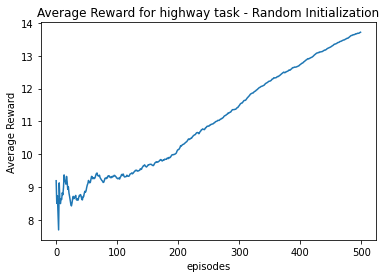

In [ ]:
plt.plot(np.mean(n_rewards3, axis = 0))
plt.title("Average Reward for highway task - Random Initialization")
plt.ylabel("Average Reward")
plt.xlabel("episodes")

### Transfer learning

In [ ]:
def n_run_2(n):
  n_rewards = []
  for i in range(n):
      # create environment
      #env = gym.make("CartPole-v1")
      env = gym.make("highway-fast-v0")
      # instantiate the policy
      policy = policy_net(env.observation_space.shape[0]*5, 20, env.action_space.n).to(device)
      policy.load_state_dict(torch.load('/content/drive/MyDrive/RL/HW5/model_weights.pth'))
      # create an optimizer
      optimizer = torch.optim.Adam(policy.parameters())
      # initialize gamma and stats
      gamma=0.99
      n_episode = 1
      returns = []
      ave_returns = []
      render_rate = 100 # render every render_rate episodes
      episode_num = 0
      while True:
          rewards = []
          actions = []
          states  = []
          # reset environment
          state, info = env.reset()
          while True:
              # render episode every render_rate epsiodes
              #if n_episode%render_rate==0:
                  #env.render()

              # calculate probabilities of taking each action
              probs = policy(torch.tensor(state.flatten()).unsqueeze(0).float().to(device)).to(device)
              # sample an action from that set of probs
              sampler = Categorical(probs)
              action = sampler.sample()

              # use that action in the environment
              new_state, reward, done,_, info = env.step(action.item())
              # store state, action and reward
              states.append(state)
              actions.append(action)
              rewards.append(reward)
              state = new_state
              if done:
                  break
          episode_num += 1
          if episode_num > 500:
            break
          # preprocess rewards
          rewards = np.array(rewards)
          # calculate rewards to go for less variance
          R = torch.tensor([np.sum(rewards[i:]*(gamma**np.array(range(i, len(rewards))))) for i in range(len(rewards))]).to(device)
          # or uncomment following line for normal rewards
          #R = torch.sum(torch.tensor(rewards))

          # preprocess states and actions
          states = torch.tensor(states).float().to(device)
          actions = torch.tensor(actions).to(device)

          # calculate gradient
          probs = policy(states.flatten(1).to(device))
          sampler = Categorical(probs)
          log_probs = -sampler.log_prob(actions)   # "-" because it was built to work with gradient descent, but we are using gradient ascent
          pseudo_loss = torch.sum(log_probs * R) # loss that when differentiated with autograd gives the gradient of J(θ)
          # update policy weights
          optimizer.zero_grad()
          pseudo_loss.backward()
          optimizer.step()

          # calculate average return and print it out
          returns.append(np.sum(rewards))
          ave_returns.append(np.mean(returns))
          print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
          n_episode += 1

      # close environment
      env.close()
      n_rewards.append(ave_returns)
  return n_rewards, policy

In [ ]:
n_rewards2, model2 = n_run_2(5)

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


Episode:      1	Avg. Return:  11.05
Episode:      2	Avg. Return:   7.95
Episode:      3	Avg. Return:   5.87
Episode:      4	Avg. Return:   6.13
Episode:      5	Avg. Return:   8.60
Episode:      6	Avg. Return:  10.23
Episode:      7	Avg. Return:  11.73
Episode:      8	Avg. Return:  11.29
Episode:      9	Avg. Return:  10.96
Episode:     10	Avg. Return:  11.08
Episode:     11	Avg. Return:  10.82
Episode:     12	Avg. Return:  10.40
Episode:     13	Avg. Return:  10.20
Episode:     14	Avg. Return:  10.58
Episode:     15	Avg. Return:  10.26
Episode:     16	Avg. Return:   9.92
Episode:     17	Avg. Return:  10.41
Episode:     18	Avg. Return:   9.93
Episode:     19	Avg. Return:  10.39
Episode:     20	Avg. Return:  10.15
Episode:     21	Avg. Return:   9.93
Episode:     22	Avg. Return:   9.95
Episode:     23	Avg. Return:   9.80
Episode:     24	Avg. Return:   9.66
Episode:     25	Avg. Return:   9.56
Episode:     26	Avg. Return:   9.34
Episode:     27	Avg. Return:   9.43
Episode:     28	Avg. Return:

In [ ]:
torch.save(model2.state_dict(), '/content/drive/MyDrive/RL/HW5/model_weights2.pth')

Text(0.5, 0, 'episodes')

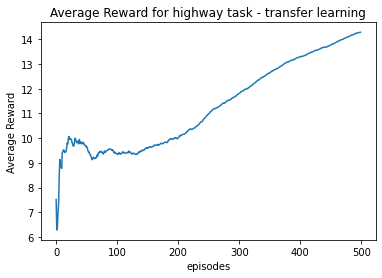

In [ ]:
plt.plot(np.mean(n_rewards2, axis = 0))
plt.title("Average Reward for highway task - transfer learning")
plt.ylabel("Average Reward")
plt.xlabel("episodes")

Text(0.5, 0, 'episodes')

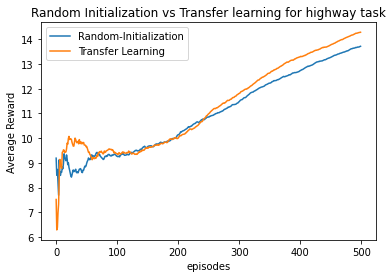

In [ ]:
plt.plot(np.mean(n_rewards3, axis = 0))
plt.plot(np.mean(n_rewards2, axis = 0))

plt.legend(['Random-Initialization', 'Transfer Learning'])
plt.title("Random Initialization vs Transfer learning for highway task")
plt.ylabel("Average Reward")
plt.xlabel("episodes")

## Render

In [ ]:
!apt install -y python-opengl ffmpeg > /dev/null 2>&1
%pip install pyvirtualdisplay highway-env stable_baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 29.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.0/170.0 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install xvfbwrapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-py3-none-any.whl size=5023 sha256=b22417363701b501e489d2678ee046b02cc5480457347a7baeab683c715a3a12
  Stored in directory: /root/.cache/pip/wheels/e1/da/b4/57ac130c024104997ae76f389fe0e7e43922ec3cfdffaf1b1e
Successfully built xvfbwrapper


In [ ]:
!apt update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,479 kB]
Get:14 http://archive

In [ ]:
!apt install xvfb


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 28 not upgraded.
Need to get 780 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 xvfb amd64 2:1.20.13-1ubuntu1~20.04.6 [780 kB]
Fetched 780 kB in 1s (535 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 130514 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.20.13-1ubuntu1~20.04.6_amd64.deb ...
Unpacking xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Setting up xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Processing triggers for man-db (2.9.1-1) ...


In [ ]:
!pip3 install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()


from matplotlib import pyplot as plt, animation
%matplotlib inline
from IPython import display

def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)


class trigger:
    def __init__(self):
        self._trigger = True

    def __call__(self, e):
        return self._trigger

    def set(self, t):
        self._trigger = t

### Merge Enviorment

In [ ]:
env = gym.make("merge-v0")
model = policy_net(25, 20, 5)
model.load_state_dict(torch.load('/content/drive/MyDrive/RL/HW5/model_weights.pth'))

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


<All keys matched successfully>

In [ ]:
frames = []
state , info= env.reset()
for _ in range(30):
    probs = model(torch.tensor(state.flatten()).unsqueeze(0).float())
    # sample an action from that set of probs
    sampler = Categorical(probs)
    action = sampler.sample()
    #action = env.action_type.actions_indexes["IDLE"]
    frames.append(env.render(mode='rgb_array'))
    obs, reward, done, info , _= env.step(action.item())
    
env.close()

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


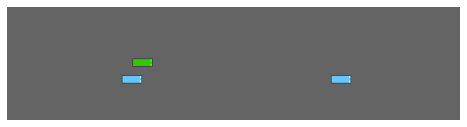

In [ ]:
display.HTML(display_anim(frames))

### Highway Enviorment with random initialization

In [ ]:
env = gym.make('highway-fast-v0')
model = policy_net(25, 20, 5)
model.load_state_dict(torch.load('/content/drive/MyDrive/RL/HW5/model3_weights.pth'))

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


<All keys matched successfully>

In [ ]:
frames = []
state , info= env.reset()
for _ in range(30):
    probs = model(torch.tensor(state.flatten()).unsqueeze(0).float())
    # sample an action from that set of probs
    sampler = Categorical(probs)
    action = sampler.sample()
    #action = env.action_type.actions_indexes["IDLE"]
    frames.append(env.render(mode='rgb_array'))
    obs, reward, done, info , _= env.step(action.item())
    
env.close()

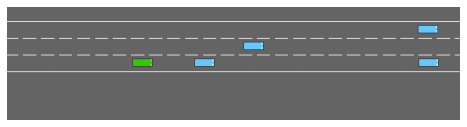

In [ ]:
display.HTML(display_anim(frames))

### Highway Enviorment with Transfer Learning


In [ ]:
env = gym.make('highway-fast-v0')
model = policy_net(25, 20, 5)
model.load_state_dict(torch.load('/content/drive/MyDrive/RL/HW5/model_weights2.pth'))

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


<All keys matched successfully>

In [ ]:
frames = []
state , info= env.reset()
for _ in range(30):
    probs = model(torch.tensor(state.flatten()).unsqueeze(0).float())
    # sample an action from that set of probs
    sampler = Categorical(probs)
    action = sampler.sample()
    #action = env.action_type.actions_indexes["IDLE"]
    frames.append(env.render(mode='rgb_array'))
    obs, reward, done, info , _= env.step(action.item())
    

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


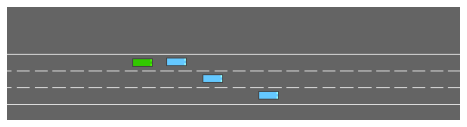

In [ ]:
display.HTML(display_anim(frames))